## Section D. Ridge Regression


In [1]:
options(warn=-1)
library(ggplot2) 
library(reshape2)
set.seed(1234)

### 3.Implementing the SGD and BGD regression.

In [2]:
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
   n_weights = dim(W)[1]
   errors = matrix(,nrow=n_weights, ncol=2)
   for (tau in 1:n_weights) {
      errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
      #errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
   }
   return(errors)
}

### Implementation of Stochastic Gradient Descent

In [3]:
##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}



In [4]:
# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # MODIFY THIS FUNCTION FOr L2 REG
   grad = - (y_true-y_pred) * x +  (lambda * W_prev)
   return(W_prev - eta * grad)
}

error_sgd <- function() {
   ## reading the data
   dtrain = read_data("Task1C_train.csv", TRUE)
   dtest = read_data("Task1C_test.csv", TRUE)
 
   ##### SGD Trainng
   max_epoch = 20
   epsilon = .001
   eta = .01
   lambda=0

   train_res = sgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
   errors = get_errors(dtrain, dtest, train_res$W) 
   return(errors) 
}

In [5]:
error.sgd<-error_sgd()

### Implementation of Batch Gradient Descent.

In [6]:
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}



##--- Batch Gradient Descent --------------------------------------------
bgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]

   W <- matrix(,nrow=(max_epoch+1), ncol=ncol(train_x))
   W[1,] <- runif(ncol(train_x))

   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=(max_epoch+1), ncol=1)
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   trainin_size = dim(train_x)[1]
   for (tau in 1:max_epoch){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}

       # make prediction over the training set
       y_pred = train_x %*% W[tau,]

       # update the weight you may decide to chose linea search or not (we are not using line search here)
       W[tau+1,] = bgd_update_weight(W[tau,], train_x, train_y, y_pred, lambda, eta)

       # keep track of the objective funtion
       obj_func_val[tau+1,1] = train_obj_func(train_x, W[tau+1,],train_y, lambda)
   } 
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}


In [7]:
# updating the weight vector
bgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # MODIFY THIS FUNCTION FOr L2 REG
   grad = -colMeans(matrix((y_true-y_pred),nrow=dim(x)[1],ncol=dim(x)[2]) * x)+(lambda * W_prev)
   return (W_prev - eta * grad)
}

train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

error_bgd <- function() {
   ## reading the data
   dtrain = read_data("Task1C_train.csv", TRUE)
   dtest = read_data("Task1C_test.csv", TRUE)

   ##### BGD Training
   max_epoch = 20
   epsilon = .001
   eta = .01
   lambda=0

   train_res = bgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
   errors = get_errors(dtrain, dtest, train_res$W)
   return(errors)
}


In [8]:
error.bgd<-error_bgd()

In [9]:
# Transforming the values
error.bgd <- cbind('idx' = seq(0,18600,930),'error' = error.bgd)

### 3.C BGD VS SGD Error Plot

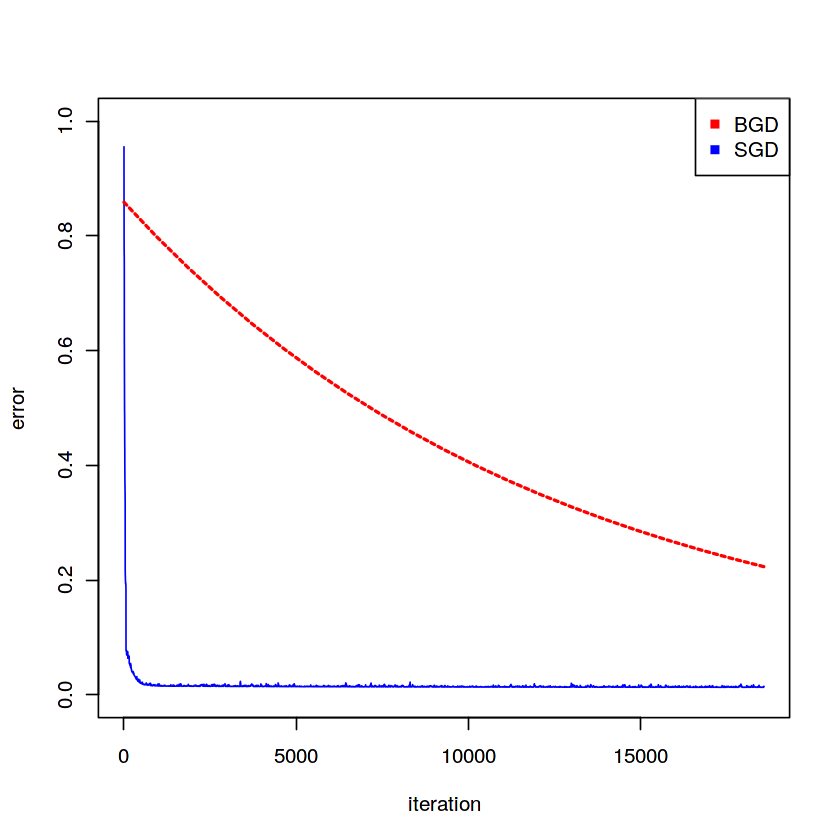

In [10]:
plot(error.sgd[,1], type="l", col="blue",ylim=c(0,1), xlab="iteration", ylab="error")
lines(x = error.bgd[,1], y = error.bgd[,2], type="l", lty=2, lwd=2, col="red")
legend("topright", legend = c("BGD", "SGD"), col=c("red", "blue"), pch = c(15,15))

### 3.D

1. The SGD convergence is fast but it is not smooth and has a lot of fluctuation.
2. The BGD convergence is slow as compared to the to the SGD but it is very smooth.